<a href="https://colab.research.google.com/github/cyuancheng/NLP_Yelp_review/blob/master/NLP_Yelp_Starbucks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing and Sentiment Analysis for Yelp Review - Starbucks in NYC


## Introduction

In this notebook, I used Natural Language Processing and Setimental Analysis to explore Yelp review data of Starbucks in New York City.

## Problem Statement

Given that the density of coffee shop is relatively high in New York City, a set of data about consumer's review of Starbucks from Yelp will help business for small coffee shops. For example, the result can be used to improve the service based on the negative review. To accomplish this task, I will use Yelp API to explore the customer review data of Starbucks in Rockfeller Center in New York City.

In [26]:
import pandas as pd
import numpy as np
import requests
import spacy #use NLP functions
from spacy import displacy
from textblob import TextBlob
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import folium
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data pre-process 
Get data from Yelp API
(50 Starbucks stores within 40 km near Rockefeller Center in NYC)
* Yelp API only allows to get information from 50 stores, so we will focus on Starbucks stores near Rockefeller Center

In [0]:
#get yelp api (https://www.yelp.com/developers)

client_id = 'fl6Gc_WOT5VLrae0o6fc7w' 
key = 'kArR8ttjf4JdZDtC27-InwcgepdkWrtTcSfaHKwf_JMtQY0LvXgfaG3lmUA3F2oCCp-KUa-W8tPuVXdm8Abwj6N0m0YJniJHVa61rXEFMLuAM11d2IrYSV5NEYGJXHYx'

ENDPOINT = 'https://api.yelp.com/v3/businesses/search'

HEADERS = {'Authorization':'bearer {}'.format(key)}

PARAMETERS = {'term' : 'Starbucks',
              'limit':50,
             'radius':40000, # meter
              'latitude': 40.758862,
              'longitude':-73.978663  # Rockefeller Center
              #'sort_by' :'review_count', 
             #'location':"New York City"
             }

response = requests.get(url = ENDPOINT, params = PARAMETERS, headers = HEADERS)

### Get the data from Yelp API 
Look at the first business. Yelp data is in json format.

In [28]:
data = response.json()
data["businesses"][0]

{'alias': 'starbucks-new-york-273',
 'categories': [{'alias': 'coffee', 'title': 'Coffee & Tea'}],
 'coordinates': {'latitude': 40.758856, 'longitude': -73.978954},
 'display_phone': '(212) 397-7950',
 'distance': 24.51886376624723,
 'id': '5WHpzFh-ZbTBY919PlZPTw',
 'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/YQnJCspcF9jey1Qu2ZeV7g/o.jpg',
 'is_closed': False,
 'location': {'address1': '30 Rockefeller Plz',
  'address2': '',
  'address3': '',
  'city': 'New York',
  'country': 'US',
  'display_address': ['30 Rockefeller Plz', 'New York, NY 10112'],
  'state': 'NY',
  'zip_code': '10112'},
 'name': 'Starbucks',
 'phone': '+12123977950',
 'price': '$$',
 'rating': 3.0,
 'review_count': 84,
 'transactions': [],
 'url': 'https://www.yelp.com/biz/starbucks-new-york-273?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=fl6Gc_WOT5VLrae0o6fc7w'}

Next, we can make a list of the businesses with their id, rating, price, and location

In [0]:
# list of id in businesses with rating
list_buss = []

for item in data['businesses']:
  try:
    list_buss.append([item['id'], item['rating'], item['price'],item['review_count'],\
                      item['coordinates']['latitude'],item['coordinates']['longitude'] ])
  except:
    list_buss.append([item['id'], item['rating'], None, None, None, None])

In [30]:
# convert to pandas format
list_buss = pd.DataFrame(list_buss, columns = ['id','rating','price', 'count', 'latitude','longitude' ])
list_buss.head()

,id,rating,price,count,latitude,longitude
0,5WHpzFh-ZbTBY919PlZPTw,3.0,$$,84.0,40.758856,-73.978954
1,AJR1lIu3RzgC8bgCk2tFog,2.5,$$,31.0,40.758859,-73.978956
2,t8_nm5-yk8ArhZjT3nHxRA,2.0,$$,24.0,40.757794,-73.979604
3,W5GNNwxMeKMRvQJwtVnJdA,2.5,$$,23.0,40.760609,-73.978432
4,4VwDtb5wOxfaXFOvTp7C6A,2.0,$$,25.0,40.760587,-73.978598


show the business location on the map

In [31]:
locations = list_buss[['latitude', 'longitude']].dropna()
locationlist = locations.values.tolist()  # put all the locations in a list
print('There are',len(locationlist),'starbucks in the dataset')

There are 48 starbucks in the dataset


In [32]:
map = folium.Map(location=[40.758862, -73.978663], zoom_start=15)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=list_buss['id'][point]).add_to(map)
map

We set the 40000 meter radius on the Yelp API,  but the actural radius is much lower than the 40000 meter in the dense area due to high business density.

### Get customer review data
Get consumer review data from business id. But each business only has three reviews from Yelp API.


In [33]:
data["businesses"][0]['id'] # parse id# for review 

'5WHpzFh-ZbTBY919PlZPTw'

read review of this businesses 

In [0]:
ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/5WHpzFh-ZbTBY919PlZPTw/reviews'   # id/reviews  
response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)

Each business has three reviews. Read first review

In [35]:
print('Number of review in each business =',len(response_reviews.json()))

Number of review in each business = 3


In [36]:
response_reviews.json()['reviews'][0]#['user']['id']#['profile_url']

{'id': 'LKI5RWcE22FacKeZwLm4rQ',
 'rating': 4,
 'text': 'The setting is very chill. Easy to find. Employees are nice. Bathroom line sucks though.',
 'time_created': '2019-10-27 16:17:18',
 'url': 'https://www.yelp.com/biz/starbucks-new-york-273?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&hrid=LKI5RWcE22FacKeZwLm4rQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=fl6Gc_WOT5VLrae0o6fc7w',
 'user': {'id': 'HFvqZIt9Uz73sNeGejQhMg',
  'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/xuYrQDZIK9gWOZuquKgzZQ/o.jpg',
  'name': 'Christina E.',
  'profile_url': 'https://www.yelp.com/user_details?userid=HFvqZIt9Uz73sNeGejQhMg'}}

Since each buisness only has three reviews, the rating are not representive the business statistically. So I decide to pull out the rating that directly link to the reviewer (user).

In [0]:
# collect review
List = []
for i in range(50):
  try:
    a = data["businesses"][i]['id']
    ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/'+ a +'/reviews'
    response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)
    for ii in range(3):
      b = response_reviews.json()['reviews'][ii]['user']['id']
      c = response_reviews.json()['reviews'][ii]['text']
      d = response_reviews.json()['reviews'][ii]['rating']
      e = response_reviews.json()['reviews'][ii]['time_created']
      List.append([a,b,c,d,e])   
  except:
    List.append([a, None, None, None, None])
    #pass

In [38]:
df_total = pd.DataFrame(List, columns = ["buss_id", "user_id", "review", "rating", "time_created"])
df_total.head()

,buss_id,user_id,review,rating,time_created
0,5WHpzFh-ZbTBY919PlZPTw,HFvqZIt9Uz73sNeGejQhMg,The setting is very chill. Easy to find. Emplo...,4,2019-10-27 16:17:18
1,5WHpzFh-ZbTBY919PlZPTw,3URiiM_5vqsaNlywokYauw,I should really learn my lesson about ordering...,1,2019-12-05 13:25:45
2,5WHpzFh-ZbTBY919PlZPTw,egZRErMuQsvHOWRALqbYwg,My most recent visit was an awful experience. ...,1,2019-10-12 22:36:25
3,AJR1lIu3RzgC8bgCk2tFog,L261dYh3HYs28hnYs23yIQ,I arrived extremely early in NY so I decided t...,3,2018-03-02 05:34:23
4,AJR1lIu3RzgC8bgCk2tFog,6G2PoWSsNBQE6ofCBlno0g,TUESDAY Dec 3rd- 8:58 pm- Awfully choice to b...,1,2019-12-03 18:05:46


In [0]:
df_total = df_total[~df_total['review'].isnull()] # remove missing data

In [41]:
df_total['review'][20]

'Rude service, unbearably loud and whiny hip-hop music (and I generally like the genre), clueless tourist clientele who have loud speakerphone conversations...'

In [42]:
print('Total number of reivew = ',len(df_total))

Total number of reivew =  150


In [43]:
df_total['time_created'] = pd.to_datetime(df_total['time_created'])
df_total.index = df_total['time_created']
df_total = df_total.drop(columns=['time_created'])
df_total.head()

,buss_id,user_id,review,rating
time_created,,,,
2019-10-27 16:17:18,5WHpzFh-ZbTBY919PlZPTw,HFvqZIt9Uz73sNeGejQhMg,The setting is very chill. Easy to find. Emplo...,4
2019-12-05 13:25:45,5WHpzFh-ZbTBY919PlZPTw,3URiiM_5vqsaNlywokYauw,I should really learn my lesson about ordering...,1
2019-10-12 22:36:25,5WHpzFh-ZbTBY919PlZPTw,egZRErMuQsvHOWRALqbYwg,My most recent visit was an awful experience. ...,1
2018-03-02 05:34:23,AJR1lIu3RzgC8bgCk2tFog,L261dYh3HYs28hnYs23yIQ,I arrived extremely early in NY so I decided t...,3
2019-12-03 18:05:46,AJR1lIu3RzgC8bgCk2tFog,6G2PoWSsNBQE6ofCBlno0g,TUESDAY Dec 3rd- 8:58 pm- Awfully choice to b...,1


In [46]:
print(min(df_total.index), max(df_total.index))

2011-05-03 21:30:42 2019-12-29 10:52:24


The review was from May 2011 to Dec 2019.

### Clean text

Next, we need to clean the text before the machine learning. Below, I create a function to clean text data that performs several transformations:

- lower the text
- tokenize the text and remove the punctuation
- remove useless words that contain numbers
- remove stop words
- Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
- lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)

In [0]:
def get_wordnet_pos(pos_tag):
  '''
  return the wordnet object value 
  corresponding to the POS tag
  '''

  if pos_tag.startswith('J'):
        return wordnet.ADJ
  elif pos_tag.startswith('V'):
        return wordnet.VERB
  elif pos_tag.startswith('N'):
        return wordnet.NOUN
  elif pos_tag.startswith('R'):
        return wordnet.ADV
  else:
        return wordnet.NOUN

# clean words
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [0]:
df_total["review_clean"] = df_total["review"].apply(lambda x: clean_text(x))

In [50]:
df_total.head()

,buss_id,user_id,review,rating,review_clean
time_created,,,,,
2019-10-27 16:17:18,5WHpzFh-ZbTBY919PlZPTw,HFvqZIt9Uz73sNeGejQhMg,The setting is very chill. Easy to find. Emplo...,4,set chill easy find employee nice bathroom lin...
2019-12-05 13:25:45,5WHpzFh-ZbTBY919PlZPTw,3URiiM_5vqsaNlywokYauw,I should really learn my lesson about ordering...,1,really learn lesson order location typically g...
2019-10-12 22:36:25,5WHpzFh-ZbTBY919PlZPTw,egZRErMuQsvHOWRALqbYwg,My most recent visit was an awful experience. ...,1,recent visit awful experience line well manage...
2018-03-02 05:34:23,AJR1lIu3RzgC8bgCk2tFog,L261dYh3HYs28hnYs23yIQ,I arrived extremely early in NY so I decided t...,3,arrive extremely early ny decide grab cup coff...
2019-12-03 18:05:46,AJR1lIu3RzgC8bgCk2tFog,6G2PoWSsNBQE6ofCBlno0g,TUESDAY Dec 3rd- 8:58 pm- Awfully choice to b...,1,tuesday dec pm awfully choice buy hot chocolat...


Now, we have clean review data. We can do feature engineering prior to ML.

## Feautre Engineering

Firstly, we use Vader to add sentiment analysis features from the review. Vader uses a lexicon of words to find positive or  negatives. For each text, Vader returns 4 values: negative, neutral, postive, and compound.

https://github.com/cjhutto/vaderSentiment

> VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in text.

- The Positive, Negative and Neutral scores represent the proportion of text that falls in these categories. All these scores should add up to 1.
- The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

In [0]:
SIA = SentimentIntensityAnalyzer()
df_total["sentiments"] = df_total["review"].apply(lambda x: SIA.polarity_scores(x))
df_total = pd.concat([df_total.drop(['sentiments'], axis=1), df_total['sentiments'].apply(pd.Series)], axis=1)

Next, we use TextBolb to get polarity and subjectivity from review. 

https://textblob.readthedocs.io/en/dev/

- Polarity is a float value within the range [-1.0 to 1.0] where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.
- Subjectivity is a float value within the range [0.0 to 1.0] where 0.0 is very objective and 1.0 is very subjective. Subjective sentence expresses some personal feelings, views, beliefs, opinions, allegations, desires, beliefs, suspicions, and speculations where as Objective sentences are factual.

In [0]:
df_total['polarity'] = df_total["review"].apply(lambda x: TextBlob(x).sentiment[0])
df_total['subjectivity'] = df_total["review"].apply(lambda x: TextBlob(x).sentiment[1])

In [53]:
df_total.head(3)

,buss_id,user_id,review,rating,review_clean,neg,neu,pos,compound,polarity,subjectivity
time_created,,,,,,,,,,,
2019-10-27 16:17:18,5WHpzFh-ZbTBY919PlZPTw,HFvqZIt9Uz73sNeGejQhMg,The setting is very chill. Easy to find. Emplo...,4,set chill easy find employee nice bathroom lin...,0.122,0.586,0.292,0.5390,0.233333,0.608333
2019-12-05 13:25:45,5WHpzFh-ZbTBY919PlZPTw,3URiiM_5vqsaNlywokYauw,I should really learn my lesson about ordering...,1,really learn lesson order location typically g...,0.000,1.000,0.000,0.0000,0.016667,0.350000
2019-10-12 22:36:25,5WHpzFh-ZbTBY919PlZPTw,egZRErMuQsvHOWRALqbYwg,My most recent visit was an awful experience. ...,1,recent visit awful experience line well manage...,0.167,0.833,0.000,-0.5878,0.006667,0.716667


In [0]:
# add number of characters column
df_total["num_chars"] = df_total["review"].apply(lambda x: len(x))

# add number of words column
df_total["num_words"] = df_total["review"].apply(lambda x: len(x.split(" ")))

Create doc2vec columns

In [0]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_total["review_clean"].apply(lambda x: x.split(" ")))]
# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df_total["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df_total = pd.concat([df_total, doc2vec_df], axis=1)

In [56]:
df_total.head(3)

,buss_id,user_id,review,rating,review_clean,neg,neu,pos,compound,polarity,subjectivity,num_chars,num_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
time_created,,,,,,,,,,,,,,,,,,
2019-10-27 16:17:18,5WHpzFh-ZbTBY919PlZPTw,HFvqZIt9Uz73sNeGejQhMg,The setting is very chill. Easy to find. Emplo...,4,set chill easy find employee nice bathroom lin...,0.122,0.586,0.292,0.5390,0.233333,0.608333,88,15,0.084356,0.024179,0.093419,-0.052576,-0.048951
2019-12-05 13:25:45,5WHpzFh-ZbTBY919PlZPTw,3URiiM_5vqsaNlywokYauw,I should really learn my lesson about ordering...,1,really learn lesson order location typically g...,0.000,1.000,0.000,0.0000,0.016667,0.350000,155,28,0.020323,0.048994,-0.000092,-0.024238,0.009615
2019-10-12 22:36:25,5WHpzFh-ZbTBY919PlZPTw,egZRErMuQsvHOWRALqbYwg,My most recent visit was an awful experience. ...,1,recent visit awful experience line well manage...,0.167,0.833,0.000,-0.5878,0.006667,0.716667,157,27,-0.072980,-0.024567,-0.069383,-0.095484,0.066531


Add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df_total["review_clean"]).toarray()
# create dataframe
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
# modify column names
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df_total.index

df_total = pd.concat([df_total, tfidf_df], axis=1)

In [58]:
df_total.head(2)

,buss_id,user_id,review,rating,review_clean,neg,neu,pos,compound,polarity,subjectivity,num_chars,num_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_always,word_bad,word_busy,word_coffee,word_come,word_customer,word_drink,word_friendly,word_get,word_go,word_good,word_great,word_like,word_line,word_location,word_morning,word_nice,word_one,word_order,word_place,word_really,word_right,word_service,word_staff,word_starbucks,word_take,word_time,word_ve,word_work
time_created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-27 16:17:18,5WHpzFh-ZbTBY919PlZPTw,HFvqZIt9Uz73sNeGejQhMg,The setting is very chill. Easy to find. Emplo...,4,set chill easy find employee nice bathroom lin...,0.122,0.586,0.292,0.539,0.233333,0.608333,88,15,0.084356,0.024179,0.093419,-0.052576,-0.048951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.676481,0.000000,0.0,0.73646,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2019-12-05 13:25:45,5WHpzFh-ZbTBY919PlZPTw,3URiiM_5vqsaNlywokYauw,I should really learn my lesson about ordering...,1,really learn lesson order location typically g...,0.000,1.000,0.000,0.000,0.016667,0.350000,155,28,0.020323,0.048994,-0.000092,-0.024238,0.009615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343494,0.0,0.0,0.0,0.000000,0.402073,0.0,0.00000,0.369732,0.351704,0.0,0.504984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.452706


In [59]:
df_total.shape

(150, 47)

## Exploratory data analysis

Look at the user's activity

In [60]:
df_total[df_total['user_id']=="Hi10sGSZNxQH3NLyWSZ1oA"]

,buss_id,user_id,review,rating,review_clean,neg,neu,pos,compound,polarity,subjectivity,num_chars,num_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_always,word_bad,word_busy,word_coffee,word_come,word_customer,word_drink,word_friendly,word_get,word_go,word_good,word_great,word_like,word_line,word_location,word_morning,word_nice,word_one,word_order,word_place,word_really,word_right,word_service,word_staff,word_starbucks,word_take,word_time,word_ve,word_work
time_created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-14 02:07:21,8NHISsd0gKhyPNJoqhEqnA,Hi10sGSZNxQH3NLyWSZ1oA,Don't sneer at me for reviewing Starbucks. Oth...,3,sneer review starbucks otherwise sneerbucks.\n...,0.000,1.000,0.000,0.0000,0.0,0.5,157,26,0.027435,0.000041,0.092659,-0.057262,0.021210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.576422,0.0,0.511935,0.636915,0.0
2019-03-14 02:20:39,lSncUPNBY-qs_QOtEOpkVA,Hi10sGSZNxQH3NLyWSZ1oA,I brought my dog in here. He didn't like it. H...,2,brought dog like start snarlbucks.\n\nthere se...,0.140,0.860,0.000,-0.4973,0.2,0.2,157,29,-0.070183,-0.043160,-0.052450,0.037170,0.008655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.832505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506795,0.0,0.0,0.0,0.223817,0.0,0.000000,0.000000,0.0
2019-03-15 03:02:14,UgjaEX9ssUmISd63QdLiyw,Hi10sGSZNxQH3NLyWSZ1oA,"I got scared that I was about to pee myself, s...",3,get scared pee go scarebucks.\n\ni'm grateful ...,0.093,0.801,0.106,0.1010,0.2,0.3,159,29,-0.066323,0.061557,-0.093532,0.088465,0.014330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.660658,0.629621,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.408789,0.0,0.000000,0.000000,0.0


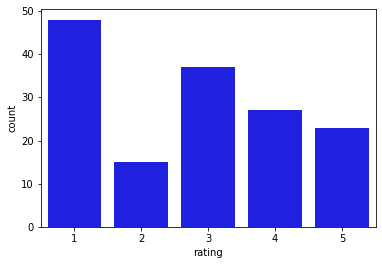

In [61]:
sns.countplot(x="rating", data=df_total, color='b')

The rating data is imbalance.

Look at the correlation:

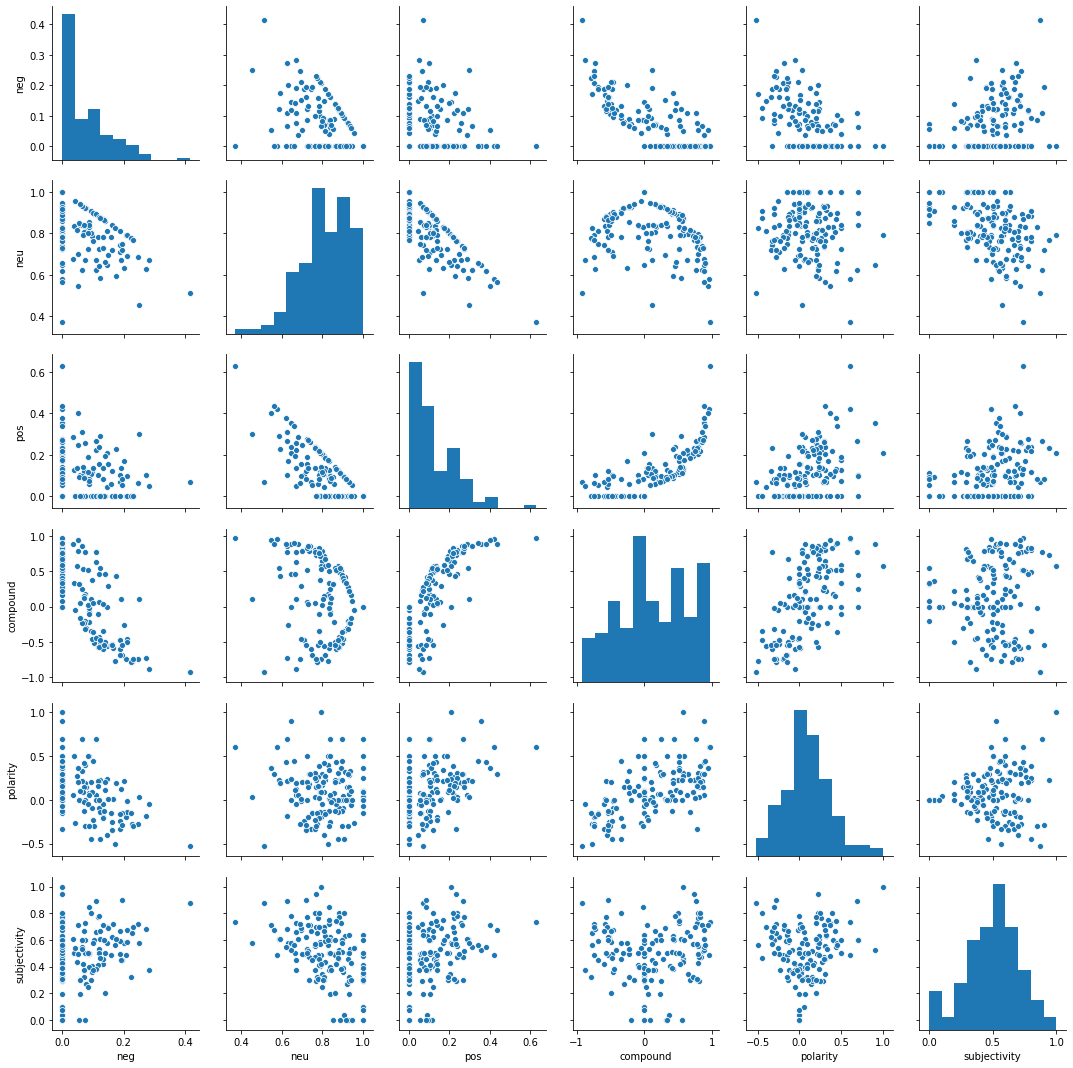

In [62]:
sns.pairplot(df_total[['neg',	'neu',	'pos',	'compound',	'polarity',	'subjectivity']])

print word clouds for low rating

In [0]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 50, 
        scale = 5,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 16)
        fig.subplots_adjust(top = 2.25)

    plt.imshow(wordcloud)
    plt.show()
    

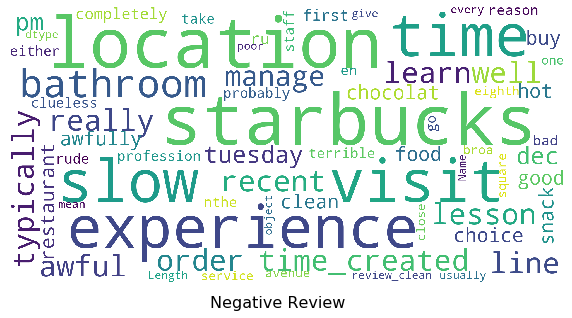

In [118]:
# print wordcloud (low rating)
show_wordcloud(df_total[df_total['rating']<3]["review_clean"], title='Negative Review')

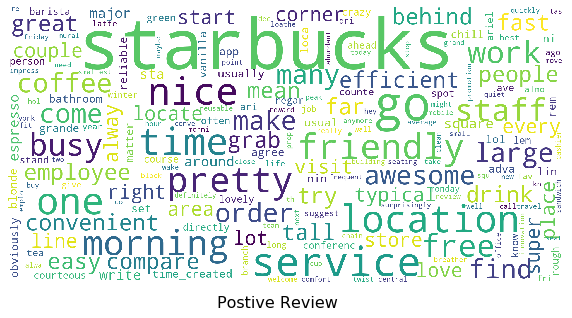

In [119]:
# print wordcloud (low rating)
show_wordcloud(df_total[df_total['rating']>3]["review_clean"], title='Postive Review')

In [67]:
# highest positive sentiment reviews
df_total.sort_values("pos", ascending = False)[["review", "pos", 'compound','polarity',	'subjectivity','rating']].head(5)

,review,pos,compound,polarity,subjectivity,rating
time_created,,,,,,
2018-11-11 14:07:54,Easy grab n go! Typical awesome service and St...,0.629,0.9622,0.610000,0.736667,5
2019-10-14 03:32:42,Nice Starbucks. Super slow realllly early in t...,0.437,0.8774,0.301667,0.673333,4
2019-03-12 05:09:44,My fav Starbucks at corner of my job makes the...,0.422,0.9552,0.606667,0.486667,5
2018-09-03 10:27:25,I loathe going to chains when I travel but had...,0.403,0.9451,0.361905,0.711905,5
2019-12-10 11:20:01,I work around the corner and love this Starbuc...,0.380,0.8860,0.437500,0.550000,5


In [68]:
# highest negative sentiment reviews 
df_total.sort_values("neg", ascending = False)[["review", "neg", 'compound','polarity',	'subjectivity','rating']].head(5)

,review,neg,compound,polarity,subjectivity,rating
time_created,,,,,,
2019-11-29 12:56:38,Absolutely the worst Starbucks I have ever vis...,0.415,-0.9192,-0.525000,0.875000,1
2018-04-17 17:32:48,I usually like this location but tonight reall...,0.282,-0.8844,-0.050000,0.370833,1
2019-11-13 06:24:20,LOL - shop lifters galore in this FREEZING col...,0.274,-0.7255,-0.183333,0.683333,1
2019-04-12 06:44:43,*Complaint filed successfully with credit reim...,0.249,0.1114,0.030000,0.573333,1
2018-11-06 09:57:29,"The staff here is terrible. Either rude, cluel...",0.246,-0.7430,-0.275000,0.722222,1


How is the review rating correlated to the sentiment?

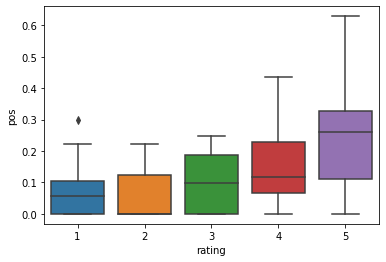

In [69]:
sns.boxplot(x="rating", y="pos", data=df_total)

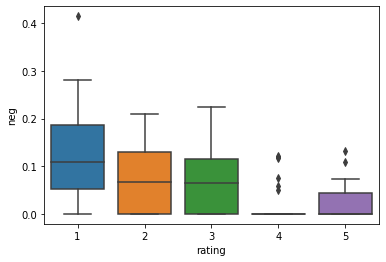

In [70]:
sns.boxplot(x="rating", y="neg", data=df_total)

High rating has postive sentiment, while low rating has negative sentiment.

In [0]:
# plot sentiment distribution for positive and negative reviews
def plot_rating(name = 'polarity'):
  for x in [1,2,3,4,5]:
    subset = df_total[df_total['rating'] == x]
    # Draw the density plot
    if x == 1:
      label = "rating = 1"
    elif x == 2:
      label = 'rating = 2'
    elif x == 3:
      label ='rating = 3'
    elif x == 4:
      label = 'rating = 4'  
    else:
      label = "rating = 5"
    sns.distplot(subset[name], hist = False, label = label)
    plt.ylabel('rating')

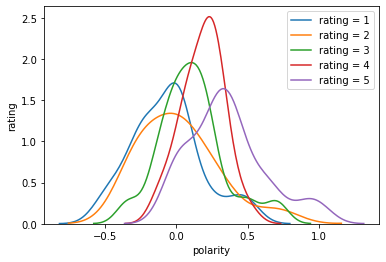

In [74]:
plot_rating(name = 'polarity')

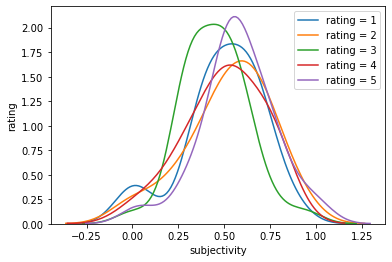

In [75]:
plot_rating(name = 'subjectivity')

distribution of subjectivity is quite similar amoung different rating

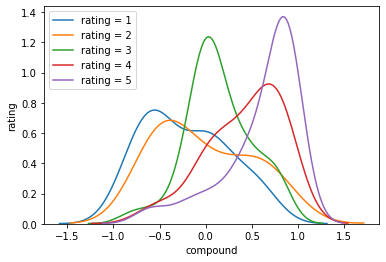

In [76]:
plot_rating(name = 'compound')

### Topic Modeling with LSA
Use Latent Semantic Analysis (LSA) to summarize the topic of the postive and negative review.


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from collections import Counter

In [0]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [0]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

Review witg high rating (postive review)

In [0]:
reindexed_data = df_total[df_total['rating']>3]['review_clean']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [0]:
## three topics
n_topics = 3
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [0]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [84]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  starbucks order service drink morning coffee nice great work friendly
Topic 2:  time square starbucks location area couple welcome foot locate seat
Topic 3:  line quickly staff busy long morning large nice location friendly


Postive reviews contain key words of "service", "friendly", "location", "quickly", etc.

Review with low rating (negative review)

In [0]:
reindexed_data = df_total[df_total['rating']<3]['review_clean']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [0]:
## three topics
n_topics = 3
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [0]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [88]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  starbucks coffee staff location ve like service time bad say
Topic 2:  order make cup water reload pay receive waited train pickup
Topic 3:  minute wait baristas door today incredibly come long cup rude


Negative reviews contain key words of "location", "service", "bad", "waited", "rude", etc.